In [1]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [5]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
# llm.invoke("who invented buld?")

AIMessage(content="The invention of the light bulb is often attributed to **Thomas Edison**, but it's more accurate to say he **perfected and commercialized** the incandescent light bulb.\n\nHere's a more detailed explanation:\n\n*   **Many Inventors Before Edison:** Several inventors before Edison had created working light bulbs. These included:\n    *   **Humphry Davy:** Created the first electric light in 1802 using a voltaic pile (early battery).\n    *   **Warren de la Rue:** Developed a light bulb with a platinum filament in 1840.\n    *   **Joseph Swan:** A British physicist, Swan independently developed a working light bulb around the same time as Edison.\n\n*   **Edison's Contribution:** Edison's key contributions were:\n    *   **A Practical and Long-Lasting Design:** He experimented with different materials for the filament and ultimately found that carbonized bamboo provided a longer-lasting and more practical light source.\n    *   **A Complete System:** Edison didn't just

In [6]:

# We need to conenect with any APIs for getting realtime prices of stocks for now we have given dummy values


from langchain_core.tools import tool


@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

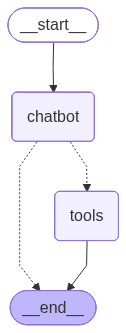

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

# ToolNode is the component that executes the tools.

# tools_condition is the mechanism that decides whether to invoke a tool 
# (and thus route to the ToolNode) or proceed with a different path in the graph.

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

graph

In [10]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [12]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [14]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)


# We can see its not doing the MAth operations 
# we need to update the setup a bit on EDGES

200.3


# Call Agent for Context

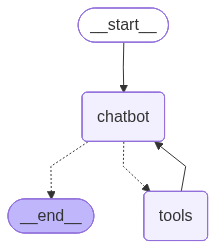

In [18]:

new_builder = StateGraph(State)

new_builder.add_node(chatbot)
new_builder.add_node("tools", ToolNode(tools))

new_builder.add_edge(START, "chatbot")
new_builder.add_conditional_edges("chatbot", tools_condition) # may or maynot call the tools
new_builder.add_edge("tools","chatbot") # send the response back to chatbot

graph = new_builder.compile()
graph


In [19]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)


The current price of AMZN is $150 and MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
Therefore, the total cost for both is $3000 + $3004.5 = $6004.5.
